# Example 6

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find errors
or would like to suggest an improvement, feel free to create an issue.

As usual we will start by importing some useful libraries.

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import matplotlib.pyplot as plt

# Salaries for Professors

The 2008--09 nine-month academic salary for Assistant Professors, Associate
Professors and Professors in a college in the U.S. The data were collected as
part of the on-going effort of the college's administration to monitor salary
differences between male and female faculty members.

- `rank` a factor with levels `AssocProf`` `AsstProf`` `Prof`.
- `discipline` a factor with levels `A` ("theoretical" departments) or ``B`` ("applied" departments).
- `yrs.since.phd` years since PhD.
- `yrs.service` years of service.
- `sex` a factor with levels `Female` `Male`.
- `salary` nine-month salary, in dollars.

This data comes with the `statsmodels` package along with some metadata. Here we
will rename a couple of variables so they are a bit easier to access.

In [19]:
salaries_dataset = sm.datasets.get_rdataset("Salaries", "carData")
#print(salaries_dataset.__doc__)
salaries_df = salaries_dataset.data
salaries_df = salaries_df.rename(columns={"yrs.since.phd": "years_post_phd", "yrs.service": "years_service", "rank": "job"})

We can use a scatter plot to get an idea for how the salary changes. There is a general trend that the salary increases through time, but the variance appears to change.

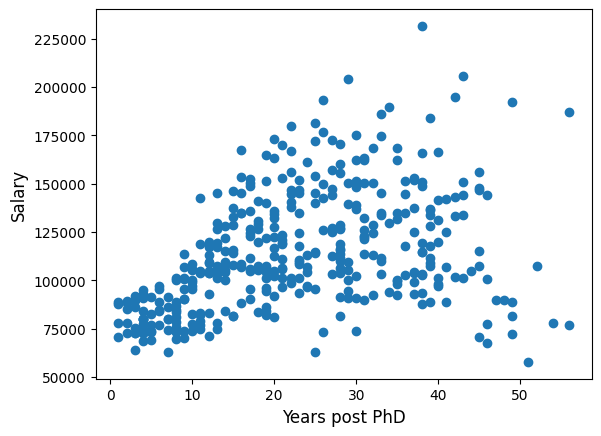

In [35]:
plt.figure()
plt.scatter(salaries_df.years_post_phd, salaries_df.salary)
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

If we colour these points based on the professors' ranks a very different
pattern emerges

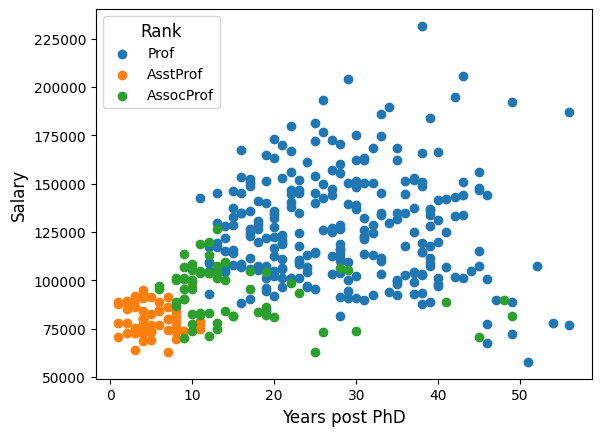

In [37]:
jobs = salaries_df["job"].unique()

plt.figure()
for job in jobs:
    tmp = salaries_df[salaries_df["job"] == job]
    plt.scatter(tmp.years_post_phd, tmp.salary, label = job)
plt.legend(title = "Rank", title_fontsize = "large")
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

### Question

What assumption of the variance component model clearly does not hold for this data set?

### Answer

The within group variance is differs wildly!

In [38]:
for job in jobs:
    print(job)
    print("mean: " + str(salaries_df[salaries_df["job"] == job].salary.mean()))
    print("scale: " + str(salaries_df[salaries_df["job"] == job].salary.std()))

Prof
mean: 126772.1090225564
scale: 27718.674998951574
AsstProf
mean: 80775.98507462686
scale: 8174.1126373976995
AssocProf
mean: 93876.4375
scale: 13831.699843745177


# Simulation

Before we analyse this data we should familiarise ourselves with the functionality provided by `statsmodels`. To have a data set where we know the "true" values we will simulate a very similar dataset. Note that we have set the mean values for each rank to the true values and set a constant scale across all the jobs of $15000$ (note $15000^{2} = 225000000$). The "years post PhD" is sampled randomly from a Poisson distribution with a relevant mean.

In [46]:
demo_job = np.repeat(a=['Prof', 'AsstProf', 'AssocProf'], repeats=100)
demo_ypp = np.concatenate(
    (stats.poisson.rvs(30, size = 100),
    stats.poisson.rvs(5, size = 100),
    stats.poisson.rvs(15, size = 100)))

demo_salary_means = [126772,80775,93876]
demo_salary_scale = 15000
demo_salary = stats.norm.rvs(loc = np.repeat(a=demo_salary_means, repeats=100), scale = demo_salary_scale, size = 300)

demo_df = pd.DataFrame({'job': demo_job,
                      'years_post_phd': demo_ypp,
                       'salary': demo_salary})
demo_df = smt.add_constant(demo_df)

jobs = demo_df["job"].unique()

We can use the same plotting code from before to confirm that this is a relevant dataset to work with.

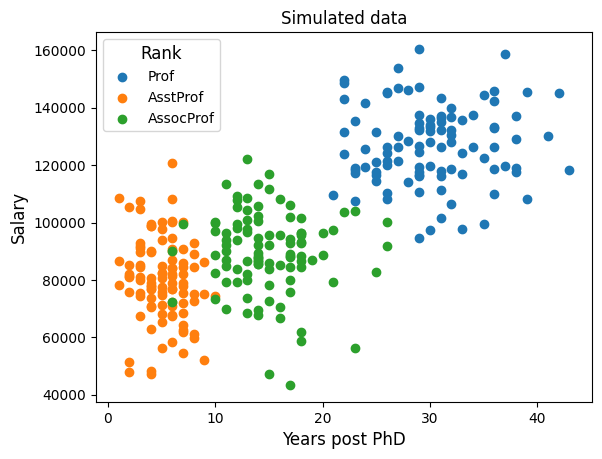

In [40]:
plt.figure()
for job in jobs:
    tmp = demo_df[demo_df["job"] == job]
    plt.scatter(tmp.years_post_phd, tmp.salary, label = job)
plt.title("Simulated data")
plt.legend(title = "Rank", title_fontsize = "large")
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

### Question

As a way to get a rough idea of the components of the variance, estimate the variance among the known means and use it to compute the variance partition coefficient (VPC) for the simulated dataset. Obviously since we are estimating the variance based on a data set of size 3 we should not put too much faith in the results.

### Answer

In [82]:
tmp = np.array(demo_salary_means)
silly_group_var_est = 0.5 * np.power(tmp - tmp.mean(), 2).sum()
silly_vpc = silly_group_var_est / (demo_salary_scale**2 + silly_group_var_est)
print(f"Silly VPC: {silly_vpc:.2f}")

Silly VPC: 0.71


### Question

Write down a way to describe the salaries with a variance components model. What parameters will be estimated?

### Answer

Let $s_{ij}$ be the salary of individual $i$ with job $j$ then

$$
s_{ij} = \beta_{0} + u_{j} + e_{ij}
$$

where $u_{j} \sim N(0, \sigma_{u}^{2})$ and $e_{ij} \sim N(0, \sigma_{e}^{2})$.

The parameters that will be estimated are $\beta_{0}$, and $\sigma_{u}^{2}$ and $\sigma_{e}^{2}$.

### Question

The following cell fits this model to the data. What are the estimated parameter values?

Hint: Due to an odd choice of names, the "Scale" parameter in the summary is the individual level variance.

In [42]:
mlm_0 = smf.mixedlm(formula = "salary ~ 1", data = demo_df, groups = demo_df.job).fit()
mlm_0.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM   Dependent Variable:   salary        
No. Observations:   300       Method:               REML          
No. Groups:         3         Scale:                199332956.5151
Min. group size:    100       Log-Likelihood:       -3289.8637    
Max. group size:    100       Converged:            Yes           
Mean group size:    100.0                                         
------------------------------------------------------------------
              Coef.      Std.Err.   z   P>|z|   [0.025    0.975]  
------------------------------------------------------------------
Intercept     98902.194 14314.356 6.909 0.000 70846.573 126957.816
Group Var 612709002.354 43589.346                                 
==================================================================

"""

### Answer

Note that because the data here have been randomly generated you may get different numbers...

- $\hat{\beta}_{0} = 1.0 \times 10^{5}$
- $\hat{\sigma}_{u}^{2} = 5.5 \times 10^{8}$
- $\hat{\sigma}_{e}^{2} = 2.3 \times 10^{8}$

### Question

Does this look reasonable?

### Answer

The value of $\beta_{0}$ (the global mean) looks reasonable given the values we simulated with and the individual level variance is approximately correct as shown in the following snippet. Given there are only three jobs (groups) it is harder to investigate if we are getting the scale correct there.

In [77]:
individual_var_est = mlm_0.scale
print(f"Estimated individual salary scale: {np.sqrt(individual_var_est):.2e}")
print(f"True individual salary scale (from simulation): {demo_salary_scale:.2e}")

print(f"\nEstimated average salary: {mlm_0.params.Intercept:.2e}")
print(f"True average salary (from simulation): {demo_df.salary.mean():.2e}")

Estimated individual salary scale: 1.41e+04
True individual salary scale (from simulation): 1.50e+04

Estimated average salary: 9.89e+04
True average salary (from simulation): 1.01e+05


### Question

Compute the VPC from the model fit. Does it agree with the previous estimate?

### Answer

Yes

In [83]:
group_var = float(mlm_0.summary().tables[1]["Coef."]["Group Var"])
vpc = group_var / (group_var + individual_var_est)
print(f"Silly VPC: {silly_vpc:.2f}")
print(f"Model VPC: {vpc:.2f}")

Silly VPC: 0.71
Model VPC: 0.75


### Question

Test whether including the effects of job is important in this model.

### Answer

The case of no job level effect is a nested model so we can use a chi-squared test to reject the null hypothesis that there is no random effect at the job level.

In [84]:
lm_1 = smf.ols(formula = "salary ~ 1", data = demo_df).fit()
mlm_llhd = mlm_0.llf
print("MLM log-likelihood")
print(mlm_llhd)

lm_llhd = lm_1.llf
print("LM log-likelihood")
print(lm_llhd)

my_chi = -2 * (lm_llhd - mlm_llhd)
print("Chi-squared statistic")
print(my_chi)

print("p-value")
print(1 - stats.chi2.cdf(my_chi, df=1))

MLM log-likelihood
-3289.8636707755886
LM log-likelihood
-3458.335073823756
Chi-squared statistic
336.9428060963346
p-value
0.0


### Question

If we were to add `years_post_phd` as a covariate, what sort of model would this be? What was the name given to this type of model in the lecture?

### Answer

It would be a random intercept model.

### Question

Fit the model including the `years_post_phd` as a covariate. Does this parameter have a significant association?

### Answer

No, as expected since the salaries were simulated independent of this value (given the job).

In [86]:
mlm_1 = smf.mixedlm(formula = "salary ~ 1 + years_post_phd", groups = demo_df.job, data = demo_df).fit()
mlm_1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM    Dependent Variable:    salary        
No. Observations:      300        Method:                REML          
No. Groups:            3          Scale:                 227693697.2471
Min. group size:       100        Log-Likelihood:        -3302.5963    
Max. group size:       100        Converged:             Yes           
Mean group size:       100.0                                           
-----------------------------------------------------------------------
                   Coef.      Std.Err.   z   P>|z|   [0.025    0.975]  
-----------------------------------------------------------------------
Intercept          99190.689 13613.327 7.286 0.000 72509.059 125872.319
years_post_phd       113.350   232.238 0.488 0.625  -341.827    568.528
Group Var      507660515.993 35009.351                                 
=======================================================================

"""

### Question

Apply the methodology above to establish if `years_post_phd` has a significant association with a Professor's salary while adjusting for random job-specific effects.

### Answer

This model does not find a significant correlation

In [87]:
mlm_2 = smf.mixedlm(formula = "salary ~ 1 + years_post_phd", groups = salaries_df.job, data = salaries_df).fit()
mlm_2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     salary        
No. Observations:     397         Method:                 REML          
No. Groups:           3           Scale:                  559427686.2492
Min. group size:      64          Log-Likelihood:         -4551.4182    
Max. group size:      266         Converged:              Yes           
Mean group size:      132.3                                             
------------------------------------------------------------------------
                   Coef.      Std.Err.   z    P>|z|   [0.025    0.975]  
------------------------------------------------------------------------
Intercept         101625.056 14327.729  7.093 0.000 73543.223 129706.889
years_post_phd       -64.770   129.922 -0.499 0.618  -319.413    189.874
Group Var      596087722.793 25613.757                                  
========================================================================

"""

### Question

How much of the variance is explained by the professors rank?

### Answer

In [103]:
print(f"VPC: {596087722.791 / (559427686.2493 + 596087722.791):.3f}")

VPC: 0.516


In [104]:
group_var = float(mlm_2.summary().tables[1]["Coef."]["Group Var"])
ind_var = mlm_2.scale
print(f"VPC: {group_var / (group_var + ind_var):.3f}")

VPC: 0.516
